---
title: 01-卷积神经网络逐步实现
date: 2018-05-19 10:17:55
tags: [神经网络系列, 笔记]
mathjax: true

---


＃ 卷积神经网络：逐步实现

欢迎来到课程4的第一项任务！在这个任务中，您将以numpy实现卷积（CONV）和池（POOL）层，包括向前传播和（可选）向后传播。

<!--more-->
**Notation**:
-  上标 $ [l] $表示$ l ^ {th} $图层的一个对象。
     - 示例：$ a ^ {[4]} $是$ 4 ^ {th} $层激活。 $ W ^ {[5]} $和$ b ^ {[5]} $是$ 5 ^ {th} $层参数。


- 上标$（i）$表示来自$ i ^ {th} $示例的对象。
     - 示例：$ x ^ {（i）} $是$ i ^ {th} $训练示例输入。
    
    
- 下标$ i $表示向量的$ i ^ {th} $条目。
    例如：$ a ^ {[l]} _ i $表示层$ l $中激活的$ i ^ {th} $条目，假设这是一个完全连接（FC）层。
    
    
-  $ n_H $，$ n_W $和$ n_C $分别表示给定层的高度，宽度和通道数量。如果你想引用一个特定的图层$ l $，你也可以编写$ n_H ^ {[l]} $，$ n_W ^ {[l]} $，$ n_C ^ {[l]} $。
 -  $ n_ {H_ {prev}} $，$ n_ {W_ {prev}} $和$ n_ {C_ {prev}} $分别表示上一层的高度，宽度和通道数量。如果引用特定层$ l $，这也可以表示为$ n_H ^ {[l-1]} $，$ n_W ^ {[l-1]} $，$ n_C ^ {[l-1]} $。

我们假设你已经熟悉`numpy`和/或完成了以前的专业化课程。让我们开始吧！

## 1 - Packages

首先导入您在此作业期间需要的所有软件包。
- [numpy](www.numpy.org) i是用Python进行科学计算的基础包。
- [matplotlib](http://matplotlib.org) 是一个用Python绘制图表的库。
- np.random.seed（1）用于保持所有随机函数调用一致。它会帮助我们为你的工作评分。

In [4]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

d:\mysites\deeplearning.ai-master\.env\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 2 - Outline of the Assignment

您将实现卷积神经网络的基本模块！您将实现的每个功能都将有详细的说明，以引导您完成所需的步骤：

- Convolution functions, including:
    - Zero Padding
    - Convolve window 
    - Convolution forward
    - Convolution backward (optional)
- Pooling functions, including:
    - Pooling forward
    - Create mask 
    - Distribute value
    - Pooling backward (optional)
    
这个笔记将要求你在`numpy`上从头开始实现这些功能。在下一个笔记本，您将使用这些函数的TensorFlow等价物来构建以下模型：

<img src="images/model.png" style="width:800px;height:300px;">

**注意**对于每个前向函数，都有相应的后向等值。因此，在您的前向模块的每一步中，您都将一些参数存储在缓存中。这些参数将用于计算反向传播期间的梯度。

## 3 - Convolutional Neural Networks

尽管编程框架使卷积易于使用，但它们仍然是深度学习中难理解的概念之一。卷积层将输入转换为不同大小的输出，如下所示。

<img src="images/conv_nn.png" style="width:350px;height:200px;">


在这部分中，您将构建卷积图层的每一步。您将首先实现两个辅助函数：一个用于零填充(zero padding)，另一个用于计算卷积函数本身。

### 3.1 - Zero-Padding

零填充在图像的边界周围添加零点：

<img src="images/PAD.png" style="width:600px;height:400px;">
<caption><center> <u> <font color='purple'> **Figure 1** </u><font color='purple'>  : **Zero-Padding**<br> Image (3 channels, RGB) with a padding of 2. </center></caption>

填充的主要好处如下：

 - 它允许您使用CONV层，而不必缩小卷的高度和宽度。这对于建立更深的网络非常重要，否则当你走向更深层时，高度/宽度会缩小。一个重要的特例是“相同”卷积，其中高度/宽度在一层之后被完全保留。

 - 它可以帮助我们在图像边界保留更多信息。如果没有填充，下一层的极少数值将受到像素边缘的影响。

**练习**：实现以下功能，将一批示例数据集X中的所有图像填充为零。[Use np.pad](https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html). 注意，如果你想为形状为$（5,5,5,5,5）$的数组“a”的第二维填充“pad = 1”，为第四维填充“pad = 3”，其余pad为0，你可以这样做：
```python
a = np.pad(a, ((0,0), (1,1), (0,0), (3,3), (0,0)), 'constant', constant_values = (..,..))
```

In [3]:
# GRADED FUNCTION: zero_pad

def zero_pad(X, pad):
    """
    用零填充数据集X的所有图像。填充应用于图像的高度和宽度，
    如图1所示。
    
    Argument:
    X -- python numpy array of shape (m, n_H, n_W, n_C) representing a batch of m images
    pad -- integer, amount of padding around each image on vertical and horizontal dimensions
    
    Returns:
    X_pad -- padded image of shape (m, n_H + 2*pad, n_W + 2*pad, n_C)
    """
    
    X_pad = np.pad(X,((0,0),(pad,pad),(pad,pad),(0,0)),'constant',constant_values = 0)
    
    return X_pad

x.shape = (4, 3, 3, 2)
x_pad.shape = (4, 7, 7, 2)
x[1,1] = [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1] = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


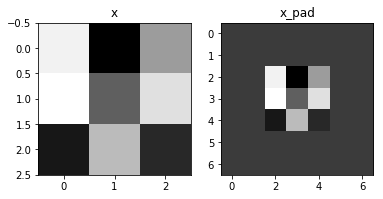

In [5]:
np.random.seed(1)
x = np.random.randn(4, 3, 3, 2)
x_pad = zero_pad(x, 2)
print ("x.shape =", x.shape)
print ("x_pad.shape =", x_pad.shape)
print ("x[1,1] =", x[1,1])
print ("x_pad[1,1] =", x_pad[1,1])

fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0,:,:,0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0,:,:,0])

**Expected Output**:

<table>
    <tr>
        <td>
            **x.shape**:
        </td>
        <td>
           (4, 3, 3, 2)
        </td>
    </tr>
        <tr>
        <td>
            **x_pad.shape**:
        </td>
        <td>
           (4, 7, 7, 2)
        </td>
    </tr>
        <tr>
        <td>
            **x[1,1]**:
        </td>
        <td>
           [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
        </td>
    </tr>
        <tr>
        <td>
            **x_pad[1,1]**:
        </td>
        <td>
           [[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]
        </td>
    </tr>

</table>

### 3.2 - Single step of convolution 


在这一部分中，实现一个卷积层，在该步骤中将滤波器应用于输入的单个位置。以下步骤被用来构建一个卷积单元，其中：

- Takes an input volume 
- Applies a filter at every position of the input
- Outputs another volume (usually of different size)

<img src="images/Convolution_schematic.gif" style="width:500px;height:300px;">
<caption><center> <u> <font color='purple'> **Figure 2** </u><font color='purple'>  : **Convolution operation**<br> with a filter of 2x2 and a stride of 1 (stride = amount you move the window each time you slide) </center></caption>

在计算机视觉应用中，左侧矩阵中的每个值对应一个像素值，我们通过将其值与原始矩阵元素化相乘，然后对它们进行求和并添加偏差，从而将3x3滤波器与图像进行卷积。在练习的第一步中，您将实现一个卷积步骤，对应于将滤波器应用于其中一个位置以获得单个实值输出。

Later in this notebook, you'll apply this function to multiple positions of the input to implement the full convolutional operation. 

**Exercise**: Implement conv_single_step(). [Hint](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.sum.html).


In [6]:
# GRADED FUNCTION: conv_single_step

def conv_single_step(a_slice_prev, W, b):
    """
    Apply one filter defined by parameters W on a single slice (a_slice_prev) of the output activation 
    of the previous layer.
    
    Arguments:
    a_slice_prev -- slice of input data of shape (f, f, n_C_prev)
    W -- Weight parameters contained in a window - matrix of shape (f, f, n_C_prev)
    b -- Bias parameters contained in a window - matrix of shape (1, 1, 1)
    
    Returns:
    Z -- a scalar value, result of convolving the sliding window (W, b) on a slice x of the input data
    """

    # Element-wise product between a_slice and W. Do not add the bias yet.
    s = np.multiply(a_slice_prev, W)
    # Sum over all entries of the volume s.
    Z = np.sum(s)
    # Add bias b to Z. Cast b to a float() so that Z results in a scalar value.
    Z = float(b)+Z

    return Z

In [7]:
np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

Z = conv_single_step(a_slice_prev, W, b)
print("Z =", Z)

Z = -6.999089450680221


**Expected Output**:
<table>
    <tr>
        <td>
            **Z**
        </td>
        <td>
            -6.99908945068
        </td>
    </tr>

</table>

### 3.3 - Convolutional Neural Networks - 正向传播

在正向传播中，您将采取多种滤波器并将它们在输入上进行卷积。每个'卷积'给你一个2D矩阵输出。然后您将堆叠这些输出以获得3D结构：

<center>
<video width="620" height="440" src="images/conv_kiank.mp4" type="video/mp4" controls>
</video>
</center>

**练习**：执行下面的函数以在输入激活A_prev上卷积滤波器W.该函数以A_prev作为输入，前一层（对于一批m个输入），F个滤波器/权重W以及一个由b表示的偏差向量输出的激活，其中每个滤波器具有其自己的（单个）偏差。最后，您还可以使用stride和pad等超参数。

**Hint**: 
1. 要选择矩阵“a_prev”（形状（5,5,3））左上角的2x2切片，您可以:
```python
a_slice_prev = a_prev[0:2,0:2,:]
```
当你在下面定义`a_slice_prev`时，这会很有用，使用你将要定义的`start / end`索引。

2.要定义a_slice，您需要首先定义它的顶点vert_start，vert_end，horiz_start和horiz_end。这个数字可能有助于您找到如何在下面的代码中使用h，w，f和s来定义每个角点。

<img src="images/vert_horiz_kiank.png" style="width:400px;height:300px;">
<caption><center> <u> <font color='purple'> **Figure 3** </u><font color='purple'>  : **Definition of a slice using vertical and horizontal start/end (with a 2x2 filter)** <br> This figure shows only a single channel.  </center></caption>


**Reminder**:
卷积的输出形状与输入形状的公式是：
$$ n_H = \lfloor \frac{n_{H_{prev}} - f + 2 \times pad}{stride} \rfloor +1 $$
$$ n_W = \lfloor \frac{n_{W_{prev}} - f + 2 \times pad}{stride} \rfloor +1 $$
$$ n_C = \text{number of filters used in the convolution}$$

对于这个练习，我们不会担心矢量化，只是用for循环来实现所有的东西。

In [8]:

def conv_forward(A_prev, W, b, hparameters):
    """
    实现卷积函数的前向传播
    
    Arguments:
    A_prev -- output activations of the previous layer, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W -- Weights, numpy array of shape (f, f, n_C_prev, n_C)
    b -- Biases, numpy array of shape (1, 1, 1, n_C)
    hparameters -- python dictionary containing "stride" and "pad"
        
    Returns:
    Z -- conv output, numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward() function
    """
    
    # Retrieve dimensions from A_prev's shape (≈1 line)  
    # 如果你不理解下面的符号可以看上面的公式
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    '''
    m: 数据样本量
    n_H_prev: 图像宽度
    n_W_prev: 图像高度
    n_C_prev: 通道数
    '''
    
    # Retrieve dimensions from W's shape (≈1 line)
    # 如果你不理解下面的符号可以看上面的公式
    (f, f, n_C_prev, n_C) = W.shape
    
    # Retrieve information from "hparameters" (≈2 lines)
    stride = hparameters['stride']
    pad = hparameters['pad']
    
    # 使用上面的公式计算卷积层输出维度. Hint: use int() to floor. (≈2 lines)
    n_H = int((n_H_prev-f+2*pad)/stride+1)
    n_W = int((n_W_prev-f+2*pad)/stride+1)
    
    # Initialize the output volume Z with zeros. (≈1 line)
    # 注意这些参数都很重要:
    # m: 样本量
    # n_H: 输出的高
    # n_W: 输出的宽
    # n_C: 输出的通道数(深度)
    Z = np.zeros([m,n_H,n_W,n_C])
    
    # Create A_prev_pad by padding A_prev
    A_prev_pad = zero_pad(A_prev, pad)
    
    for i in range(m):                               # loop over the batch of training examples
        a_prev_pad = A_prev_pad[i,:,:,:]                               # Select ith training example's padded activation
        for h in range(n_H-f+1):                           # 遍历垂直方向
            for w in range(n_W-f+1):                       # l遍历水平方向
                for c in range(n_C):                   # 遍历filter个数
                    
                    # Find the corners of the current "slice" (≈4 lines)
                    vert_start = h
                    vert_end = h+f
                    horiz_start = w
                    horiz_end = w+f
                    
                    # Use the corners to define the (3D) slice of a_prev_pad (See Hint above the cell). (≈1 line)
                    a_slice_prev = a_prev_pad[vert_start:vert_end,horiz_start:horiz_end,:]
                    
                    # Convolve the (3D) slice with the correct filter W and bias b, to get back one output neuron. (≈1 line)
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, W[:,:,:,c], b[:,:,:,c])
                                        
    # Making sure your output shape is correct
    assert(Z.shape == (m, n_H, n_W, n_C))
    
    # Save information in "cache" for the backprop
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache

In [9]:
np.random.seed(1)
A_prev = np.random.randn(10,4,4,3)
W = np.random.randn(2,2,3,8)
b = np.random.randn(1,1,1,8)
hparameters = {"pad" : 2,
               "stride": 2}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
print("Z's mean =", np.mean(Z))
print("Z[3,2,1] =", Z[3,2,1])
print("cache_conv[0][1][2][3] =", cache_conv[0][1][2][3])
print(Z.shape)

Z's mean = 0.004786321537477471
Z[3,2,1] = [ 0.10709871 -0.03102354 -0.52995452  0.98611224  0.65733641 -0.84239368
 -0.04608241  0.08802027]
cache_conv[0][1][2][3] = [-0.20075807  0.18656139  0.41005165]
(10, 4, 4, 8)


**期望结果**:

<table>
    <tr>
        <td>
            **Z's mean**
        </td>
        <td>
            0.0489952035289
        </td>
    </tr>
    <tr>
        <td>
            **Z[3,2,1]**
        </td>
        <td>
            [-0.61490741 -6.7439236  -2.55153897  1.75698377  3.56208902  0.53036437
  5.18531798  8.75898442]
        </td>
    </tr>
    <tr>
        <td>
            **cache_conv[0][1][2][3]**
        </td>
        <td>
            [-0.20075807  0.18656139  0.41005165]
        </td>
    </tr>

</table>



最后，CONV层还应包含激活，在这种情况下，我们将添加以下代码行：

```python
# Convolve the window to get back one output neuron
Z[i, h, w, c] = ...
# Apply activation
A[i, h, w, c] = activation(Z[i, h, w, c])
```

你不需要在这里做。


## 4 - Pooling layer 


池（POOL）层减少输入的高度和宽度。它有助于减少计算量，并有助于使特征检测器的输入位置更加稳定。这两种池化层是：

- 最大池化层：在输入上滑动（$ f，f $）窗口并将窗口的最大值存储在输出中。

- 平均池图层：在输入上滑动（$ f，f $）窗口并在输出中存储窗口的平均值。

<table>
<td>
<img src="images/max_pool1.png" style="width:500px;height:300px;">
<td>

<td>
<img src="images/a_pool.png" style="width:500px;height:300px;">
<td>
</table>

这些汇聚层没有反向传播训练的参数。但是，它们具有超参数，如窗口大小$ f $。这指定了您将计算最大值或平均值的fxf窗口的高度和宽度。

### 4.1 - Forward Pooling
现在，您将在相同的函数中实现MAX-POOL和AVG-POOL。

**练习**：实现池化层的正向传递。请按照下面评论中的提示进行操作。

**提醒**：
由于没有填充pad，所以将输出形状与输入形状联系起来的公式为：
$$ n_H = \lfloor \frac{n_{H_{prev}} - f}{stride} \rfloor +1 $$
$$ n_W = \lfloor \frac{n_{W_{prev}} - f}{stride} \rfloor +1 $$
$$ n_C = n_{C_{prev}}$$

In [11]:
# GRADED FUNCTION: pool_forward

def pool_forward(A_prev, hparameters, mode = "max"):
    """
    实现池化层的前向传播
    
    Arguments:
    A_prev -- Input data, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    hparameters -- python dictionary containing "f" and "stride"
    mode -- the pooling mode you would like to use, defined as a string ("max" or "average")
    
    Returns:
    A -- output of the pool layer, a numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache used in the backward pass of the pooling layer, contains the input and hparameters 
    """
    
    # Retrieve dimensions from the input shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve hyperparameters from "hparameters"
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    # Define the dimensions of the output
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev
    
    # Initialize output matrix A
    A = np.zeros((m, n_H, n_W, n_C))              
    
    for i in range(m):                         # 循环m个样本
        for h in range(n_H):                     # 循环垂直方向
            for w in range(n_W):                 # 循环水平方向
                for c in range (n_C):            # 循环通道
                    
                    # 定位 "slice" (≈4 lines)
                    vert_start = h*stride
                    vert_end = vert_start+f
                    horiz_start = w*stride
                    horiz_end = horiz_start+f
                    
                    # 用定位来生成切片. (≈1 line)
                    a_prev_slice = A_prev[vert_start:vert_end,horiz_start:horiz_end,c]
                    
                    # Compute the pooling operation on the slice. Use an if statment to differentiate the modes. Use np.max/np.mean.
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_prev_slice)
                    elif mode == "average":
                        A[i, h, w, c] = np.mean(a_prev_slice)
    
    
    # Store the input and hparameters in "cache" for pool_backward()
    cache = (A_prev, hparameters)
    
    # Making sure your output shape is correct
    assert(A.shape == (m, n_H, n_W, n_C))
    
    return A, cache

In [12]:
np.random.seed(1)
A_prev = np.random.randn(2, 4, 4, 3)
hparameters = {"stride" : 2, "f": 3}

A, cache = pool_forward(A_prev, hparameters)
print("mode = max")
print("A =", A)
print()
A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A =", A)

mode = max
A = [[[[1.62434536 0.86540763 2.18557541]]]


 [[[1.62434536 0.86540763 2.18557541]]]]

mode = average
A = [[[[ 0.24481813 -0.47568152  0.3263877 ]]]


 [[[ 0.24481813 -0.47568152  0.3263877 ]]]]


**期望输出:**
<table>

    <tr>
    <td>
    A  =
    </td>
        <td>
         [[[[ 1.74481176  0.86540763  1.13376944]]]


 [[[ 1.13162939  1.51981682  2.18557541]]]]

        </td>
    </tr>
    <tr>
    <td>
    A  =
    </td>
        <td>
         [[[[ 0.02105773 -0.20328806 -0.40389855]]]


 [[[-0.22154621  0.51716526  0.48155844]]]]

        </td>
    </tr>

</table>


恭喜！您现在已经实现了卷积网络所有层的前向传递。

## 5 - 卷积神经网络中的反向传播

在现代的深度学习框架中，您只需要实现正向传播，而框架负责反向传播，所以大多数深度学习工程师不需要考虑反向传播的细节。卷积网络的反向传递很复杂。然而，如果你愿意，你可以通过的这个可选部分来了解卷积网络中的backprop。 

在之前的课程中，您实现了一个简单的（完全连接的）神经网络，您使用反向传播来计算更新loss函数参数的导数。同样，在卷积神经网络中，您可以根据loss函数计算导数以更新参数。反向传播方程不是微不足道的，我们没有在讲座中推导它们，但我们在下面简要地介绍了它们。

### 5.1 - 卷积层反向传播

我们首先实现一个CONV层的反向传播。

#### 5.1.1 - Computing dA:
这是计算$ dA $相对于特定过滤器$ W_c $和给定训练示例的loss的公式：

$$ dA += \sum _{h=0} ^{n_H} \sum_{w=0} ^{n_W} W_c \times dZ_{hw} \tag{1}$$

其中$ W_c $是一个过滤器，$ dZ_ {hw} $是一个标量，对应于第h行和第w列的conv层Z输出的成本梯度（对应于在第步走，j步走下）。请注意，在每次更新dA时，我们都会将相同的过滤器$ W_c $乘以不同的dZ。我们这样做主要是因为在计算正向传播时，每个过滤器都被不同的a_slice点分和相加。因此，在计算dA的backprop时，我们只是添加所有a_slices的渐变。
In code, inside the appropriate for-loops, this formula translates into:
```python
da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i, h, w, c]
```

#### 5.1.2 - Computing dW:
这是计算$ dW_c $（$ dW_c $是一个滤波器的导数）相对于损失的公式：

$$ dW_c  += \sum _{h=0} ^{n_H} \sum_{w=0} ^ {n_W} a_{slice} \times dZ_{hw}  \tag{2}$$

$ a_ {slice} $对应于用于生成活动$ $ {ij} $的切片。因此，这最终为我们提供了相对于该切片的$ W $的渐变。既然它是相同的$ W $，我们将只加起来所有这样的渐变来获得$ dW $。

在代码中，在适当的for循环中，该公式转换为：
```python
dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
```

#### 5.1.3 - Computing db:

这是计算$ db $相对于特定过滤器$ W_c $的成本的公式：

$$ db = \sum_h \sum_w dZ_{hw} \tag{3}$$

正如您之前在基本神经网络中看到的那样，db是通过求和$ dZ $来计算的。在这种情况下，您只需对成本输出（Z）的所有渐变进行求和。

在代码中，在适当的for循环中，该公式转换为：
```python
db[:,:,:,c] += dZ[i, h, w, c]
```

**练习**：实施下面的`conv_backward`功能。你应该总结所有的训练实例，过滤器，高度和宽度。然后，您应该使用上面的公式1,2和3来计算导数。

In [29]:
def conv_backward(dZ, cache):
    """
    实现卷积函数的反向传播
    
    Arguments:
    dZ -- 相对于loss函数的卷积层的输出（Z）的梯度，形状的numpy阵列（m，n_H，n_W，n_C）
    cache -- conv_backward（）所需值的缓存，conv_forward（）的输出
    
    Returns:
    dA_prev -- 相对于conv层的输入的loss的梯度 (A_prev),
               numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    dW -- gradient of the cost with respect to the weights of the conv layer (W)
          numpy array of shape (f, f, n_C_prev, n_C)
    db -- gradient of the cost with respect to the biases of the conv layer (b)
          numpy array of shape (1, 1, 1, n_C)
    """
    
    # Retrieve information from "cache"
    (A_prev, W, b, hparameters) = cache
    
    # Retrieve dimensions from A_prev's shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve dimensions from W's shape
    (f, f, n_C_prev, n_C) = W.shape
    
    # Retrieve information from "hparameters"
    stride = hparameters['stride']
    pad = hparameters['pad']
    
    # Retrieve dimensions from dZ's shape
    (m, n_H, n_W, n_C) = dZ.shape
    
    # Initialize dA_prev, dW, db with the correct shapes
    dA_prev = np.zeros(A_prev.shape)
    dW = np.zeros(W.shape)
    db = np.zeros(b.shape)

    # Pad A_prev and dA_prev
    A_prev_pad = zero_pad(A_prev, pad)
    dA_prev_pad = zero_pad(dA_prev, pad)
    
    for i in range(m):                       # loop over the training examples
        
        # select ith training example from A_prev_pad and dA_prev_pad
        a_prev_pad = A_prev_pad[i,:,:,:]
        da_prev_pad = dA_prev_pad[i,:,:,:]
        
        for h in range(n_H-f+1):                   # loop over vertical axis of the output volume
            for w in range(n_W-f+1):               # loop over horizontal axis of the output volume
                for c in range(n_C):           # loop over the channels of the output volume
                    
                    # Find the corners of the current "slice"
                    vert_start = h
                    vert_end = h+f
                    horiz_start = w
                    horiz_end = w+f
                    
                    # Use the corners to define the slice from a_prev_pad
                    a_slice = a_prev_pad[vert_start:vert_end,horiz_start:horiz_end,:]

                    # Update gradients for the window and the filter's parameters using the code formulas given above
                    da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] +=  W[:,:,:,c] * dZ[i, h, w, c]
                    dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
                    db[:,:,:,c] += dZ[i, h, w, c]
                    
        # Set the ith training example's dA_prev to the unpaded da_prev_pad (Hint: use X[pad:-pad, pad:-pad, :])
        dA_prev[i, :, :, :] = da_prev_pad[pad:-pad, pad:-pad, :]
    ### END CODE HERE ###
    
    # Making sure your output shape is correct
    assert(dA_prev.shape == (m, n_H_prev, n_W_prev, n_C_prev))
    
    return dA_prev, dW, db

In [30]:
np.random.seed(1)
dA, dW, db = conv_backward(Z, cache_conv)
print("dA_mean =", np.mean(dA))
print("dW_mean =", np.mean(dW))
print("db_mean =", np.mean(db))

dA_mean = -0.775945386961
dW_mean = 2.74605132882
db_mean = 0.765811445996


** Expected Output: **
<table>
    <tr>
        <td>
            **dA_mean**
        </td>
        <td>
            1.45243777754
        </td>
    </tr>
    <tr>
        <td>
            **dW_mean**
        </td>
        <td>
            1.72699145831
        </td>
    </tr>
    <tr>
        <td>
            **db_mean**
        </td>
        <td>
            7.83923256462
        </td>
    </tr>

</table>


## 5.2 Pooling layer - backward pass

接下来，我们从MAX-POOL层开始实现池化层的反向传递。即使pooling层没有backprop更新的参数，您仍然需要通过pooling层反向传播梯度，以便为在pooling层之前出现的图层计算梯度。

### 5.2.1 Max pooling - backward pass  

在跳转到pooling层的反向传播之前，您将构建一个名为`create_mask_from_window（）`的辅助函数，它执行以下操作：

$$ X = \begin{bmatrix}
1 && 3 \\
4 && 2
\end{bmatrix} \quad \rightarrow  \quad M =\begin{bmatrix}
0 && 0 \\
1 && 0
\end{bmatrix}\tag{4}$$

正如你所看到的，这个函数创建一个“蒙版”矩阵，它跟踪矩阵的最大值在哪里。 True（1）表示X中的最大位置，其他条目为False（0）。稍后您会看到，平均池的后向传导与此类似，但使用不同的蒙版。

**练习**：实现`create_mask_from_window（）`。此功能将有助于池化层的后向传导。
Hints:
-  [np.max（）]（）可能会有所帮助。它计算一个数组的最大值。
 - 如果你有一个矩阵X和一个标量x：`A =（X == x）`将会返回一个与X相同大小的矩阵A，这样：
```
A[i,j] = True if X[i,j] = x
A[i,j] = False if X[i,j] != x
```
- 在这里，你不需要考虑矩阵中有几个极大值的情况。

In [31]:
def create_mask_from_window(x):
    """
    Creates a mask from an input matrix x, to identify the max entry of x.
    
    Arguments:
    x -- Array of shape (f, f)
    
    Returns:
    mask -- Array of the same shape as window, contains a True at the position corresponding to the max entry of x.
    """
    
    ### START CODE HERE ### (≈1 line)
    mask = (x==np.max(x))
    ### END CODE HERE ###
    
    return mask

In [32]:
np.random.seed(1)
x = np.random.randn(2,3)
mask = create_mask_from_window(x)
print('x = ', x)
print("mask = ", mask)

x =  [[ 1.62434536 -0.61175641 -0.52817175]
 [-1.07296862  0.86540763 -2.3015387 ]]
mask =  [[ True False False]
 [False False False]]


**Expected Output:** 

<table> 
<tr> 
<td>

**x =**
</td>

<td>

[[ 1.62434536 -0.61175641 -0.52817175] <br>
 [-1.07296862  0.86540763 -2.3015387 ]]

  </td>
</tr>

<tr> 
<td>
**mask =**
</td>
<td>
[[ True False False] <br>
 [False False False]]
</td>
</tr>


</table>

为什么我们要跟踪最大值的位置？这是因为这是最终影响产出的输入值，最终影响到loss。 Backprop计算loss的梯度，因此任何影响最终loss的因素都应该具有非零的梯度。因此，backprop会将梯度“传播”回到影响成本的特定输入值。

### 5.2.2 - Average pooling - backward pass 

在max pooling中，对于每个输入窗口，输出上的所有“影响”都来自单个输入值 - 最大值。在average pooling中，输入窗口的每个元素对输出都有相同的影响。所以要实现backprop，你现在要实现一个反映这个的辅助函数。

例如，如果我们使用2x2过滤器在正向传球中进行了平均池化(average pooling)，那么您将用于反向传播的蒙版将如下所示：
$$ dZ = 1 \quad \rightarrow  \quad dZ =\begin{bmatrix}
1/4 && 1/4 \\
1/4 && 1/4
\end{bmatrix}\tag{5}$$

这意味着$ dZ $矩阵中的每个位置对输出的贡献相同，因为在正向传播中，我们取平均值。

**Exercise**: Implement the function below to equally distribute a value dz through a matrix of dimension shape. [Hint](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ones.html)

In [35]:
def distribute_value(dz, shape):
    """
    将输入值分布在维形状的矩阵中
    
    Arguments:
    dz -- input scalar
    shape -- the shape (n_H, n_W) of the output matrix for which we want to distribute the value of dz
    
    Returns:
    a -- Array of size (n_H, n_W) for which we distributed the value of dz
    """
    
    ### START CODE HERE ###
    # Retrieve dimensions from shape (≈1 line)
    (n_H, n_W) = shape
    
    # Compute the value to distribute on the matrix (≈1 line)
    average = dz/(n_H*n_W)
    
    # Create a matrix where every entry is the "average" value (≈1 line)
    a = average*np.ones([n_H,n_W])
    ### END CODE HERE ###
    
    return a

In [36]:
a = distribute_value(2, (2,2))
print('distributed value =', a)

distributed value = [[ 0.5  0.5]
 [ 0.5  0.5]]


**Expected Output**: 

<table> 
<tr> 
<td>
distributed_value =
</td>
<td>
[[ 0.5  0.5]
<br\> 
[ 0.5  0.5]]
</td>
</tr>
</table>

### 5.2.3 Putting it together: Pooling backward 

您现在拥有了在池化层上计算反向传播所需的所有内容。

**练习**：在两种模式下实现`pool_backward`函数（`“max”`和`“average”`）。您将再次使用4个循环（遍历训练样例，高度，宽度和通道）。你应该使用`if / elif`语句来查看模式是否等于`'max'`或`'average'`。如果它等于“average”，则应使用上面实现的`distribute_value（）`函数来创建一个与`a_slice`具有相同形状的矩阵。否则，模式等于'max'，您将使用`create_mask_from_window（）`创建一个蒙版并将其乘以相应的dZ值。

In [47]:
def pool_backward(dA, cache, mode = "max"):
    """
    实现池化层的后向传递
    
    Arguments:
    dA -- gradient of cost with respect to the output of the pooling layer, same shape as A
    cache -- cache output from the forward pass of the pooling layer, contains the layer's input and hparameters 
    mode -- the pooling mode you would like to use, defined as a string ("max" or "average")
    
    Returns:
    dA_prev -- gradient of cost with respect to the input of the pooling layer, same shape as A_prev
    """
    
    
    # Retrieve information from cache (≈1 line)
    (A_prev, hparameters) = cache
    
    # Retrieve hyperparameters from "hparameters" (≈2 lines)
    stride =hparameters['stride']
    f = hparameters['f']
    
    # Retrieve dimensions from A_prev's shape and dA's shape (≈2 lines)
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    m, n_H, n_W, n_C = dA.shape
    
    # Initialize dA_prev with zeros (≈1 line)
    dA_prev = np.zeros(A_prev.shape)
    
    for i in range(m):                       # loop over the training examples
        
        # select training example from A_prev (≈1 line)
        a_prev = A_prev[i,:,:,:]
        
        for h in range(n_H_prev-f+1):                   # loop on the vertical axis
            for w in range(n_W_prev-f+1):               # loop on the horizontal axis
                for c in range(n_C):           # loop over the channels (depth)
                    
                    # Find the corners of the current "slice" (≈4 lines)
                    vert_start = h
                    vert_end = h+f
                    horiz_start = w
                    horiz_end = w+f
                    
                    # Compute the backward propagation in both modes.
                    if mode == "max":
                        
                        # Use the corners and "c" to define the current slice from a_prev (≈1 line)
                        a_prev_slice = a_prev[vert_start:vert_end,horiz_start:horiz_end,c]
                        # Create the mask from a_prev_slice (≈1 line)
                        mask = create_mask_from_window(a_prev_slice)
                        
                        # Set dA_prev to be dA_prev + (the mask multiplied by the correct entry of dA) (≈1 line)
                        dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += np.multiply(mask,dA[i,vert_start: vert_end, horiz_start: horiz_end,c])
                        
                    elif mode == "average":
                        
                        # Get the value a from dA (≈1 line)
                        da = np.mean(dA[i, vert_start: vert_end, horiz_start: horiz_end,c])
                        # Define the shape of the filter as fxf (≈1 line)
                        shape = (f,f)
                        # Distribute it to get the correct slice of dA_prev. i.e. Add the distributed value of da. (≈1 line)
                        dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += distribute_value(da, shape)+da
                        
    # Making sure your output shape is correct
    assert(dA_prev.shape == A_prev.shape)
    
    return dA_prev

In [48]:
np.random.seed(1)
A_prev = np.random.randn(5, 5, 3, 2)
hparameters = {"stride" : 1, "f": 2}
A, cache = pool_forward(A_prev, hparameters)
dA = np.random.randn(5, 4, 2, 2)

dA_prev = pool_backward(dA, cache, mode = "max")
print("mode = max")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1])  
print()
dA_prev = pool_backward(dA, cache, mode = "average")
print("mode = average")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1]) 

mode = max
mean of dA =  0.145713902729
dA_prev[1,1] =  [[  0.           0.        ]
 [ 10.11330283  -0.49726956]
 [  0.           0.        ]]

mode = average
mean of dA =  0.145713902729
dA_prev[1,1] =  [[ 2.59843096 -0.27835778]
 [ 7.96018612 -1.95394424]
 [ 5.36175516 -1.67558646]]


**Expected Output**: 

mode = max:
<table> 
<tr> 
<td>

**mean of dA =**
</td>

<td>

0.145713902729

  </td>
</tr>

<tr> 
<td>
**dA_prev[1,1] =** 
</td>
<td>
[[ 0.          0.        ] <br>
 [ 5.05844394 -1.68282702] <br>
 [ 0.          0.        ]]
</td>
</tr>
</table>

mode = average
<table> 
<tr> 
<td>

**mean of dA =**
</td>

<td>

0.145713902729

  </td>
</tr>

<tr> 
<td>
**dA_prev[1,1] =** 
</td>
<td>
[[ 0.08485462  0.2787552 ] <br>
 [ 1.26461098 -0.25749373] <br>
 [ 1.17975636 -0.53624893]]
</td>
</tr>
</table>

### Congratulations !

恭喜完成这项任务。您现在了解了卷积神经网络的工作原理。您已经实现了神经网络的所有构建模块。在下一个作业中，您将使用TensorFlow实施一个ConvNet。